_Version log: Branch of V19. Trying out a new way of boundry checking and randomising the samples_

_Update: I resurrected V24 in order to make a nice graph demonstrating wide detectors._

In [30]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from matplotlib import pyplot as plt, lines as mpllines, patches as patches, legend_handler as mpl_legend_handler
from scipy import fft as spfft
from scipy.constants import c as C
from tqdm import tqdm
import CS_functions as cs
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})
np.set_printoptions(threshold=sys.maxsize)

def tophat(x, width):
    """
    Returns a top hat function with a given width.
    """
    return np.where(np.abs(x) <= width/2, 1, 0)

In [31]:
pixel_pitch = 0.5 # in mm
theta = 366 # in arcmins
total_points = 25
central_freq = 500e9 # in Hz
FWHM_freq = 400e9 # in Hz
read_noise = 0.0
smoothness = 50

target = cs.generate_interferogram(total_points, pixel_pitch *1e-3, central_freq, FWHM_freq, theta /60, read_noise_sigma= read_noise)
displacement = np.arange((1-total_points)//2, (1+total_points)//2, dtype= float)
displacement *= pixel_pitch
displacement = np.fft.ifftshift(displacement)

target_smooth = cs.generate_interferogram(total_points*smoothness**2, pixel_pitch/smoothness *1e-3, central_freq, FWHM_freq, theta /60, read_noise_sigma= read_noise)
displacement_smooth = np.arange((1-total_points*smoothness**2)//2, (1+total_points*smoothness**2)//2, dtype= float)
displacement_smooth *= pixel_pitch /smoothness
displacement_smooth = np.fft.ifftshift(displacement_smooth)

In [32]:
IRF_FWHM = 1.34 # in mm
sinc_half = 1.895494 # result taken from wolfram alpha. true for sinc(x) = sin(x)/x = 1/2, solve for x.
K_FWHM = sinc_half*2 /(np.pi * IRF_FWHM) # rescaling factor


IRF = 1/IRF_FWHM *tophat(displacement, IRF_FWHM) # 1D pupil function
IRF_FFT = np.fft.rfft(IRF, norm= "backward") *pixel_pitch # NORMALISE IN REAL UNITS (mm)
IRF_spec = np.abs(IRF_FFT)
IRF_smooth = 1/IRF_FWHM *tophat(displacement_smooth, IRF_FWHM) # 1D pupil function
IRF_smooth_FFT = np.fft.rfft(IRF_smooth, norm= "backward") *pixel_pitch/smoothness
IRF_smooth_spec = np.abs(IRF_smooth_FFT)


target_FFT = np.fft.rfft(target, norm= "backward") *pixel_pitch
target_FFT /= np.max(np.abs(target_FFT))
target = np.fft.irfft(target_FFT, norm= "backward") /pixel_pitch
target_spec = np.abs(target_FFT)

target_smooth_FFT = np.fft.rfft(target_smooth, norm= "backward") *pixel_pitch/smoothness
target_smooth_FFT /= np.max(np.abs(target_smooth_FFT))
target_smooth = np.fft.irfft(target_smooth_FFT, norm= "backward") /pixel_pitch*smoothness
target_smooth_spec = np.abs(target_smooth_FFT)


convol_FFT = target_FFT *IRF_FFT
convol_spec = np.abs(convol_FFT)
convol = np.fft.irfft(convol_FFT, norm= "backward", n= total_points) /pixel_pitch
convol_smooth_FFT = target_smooth_FFT *IRF_smooth_FFT
convol_smooth_spec = np.abs(convol_smooth_FFT)
convol_smooth = np.fft.irfft(convol_smooth_FFT, norm= "backward", n= total_points*smoothness**2) /(pixel_pitch/smoothness)


wavenum = np.fft.rfftfreq(len(target), pixel_pitch) # in mm^-1
freqs = wavenum*10**3 * C / (2*np.sin(np.deg2rad(theta/60))) # in Hz
freqs *= 1e-12 # in THz
wavenum_smooth = np.fft.rfftfreq(len(target_smooth), pixel_pitch/smoothness) # in mm^-1
freqs_smooth = wavenum_smooth*10**3 * C / (2*np.sin(np.deg2rad(theta/60))) # in Hz
freqs_smooth *= 1e-12 # in THz

C:\Users\rcr73298\AppData\Local\Temp\ipykernel_25208\3644681977.py:7: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axs[0].legend()


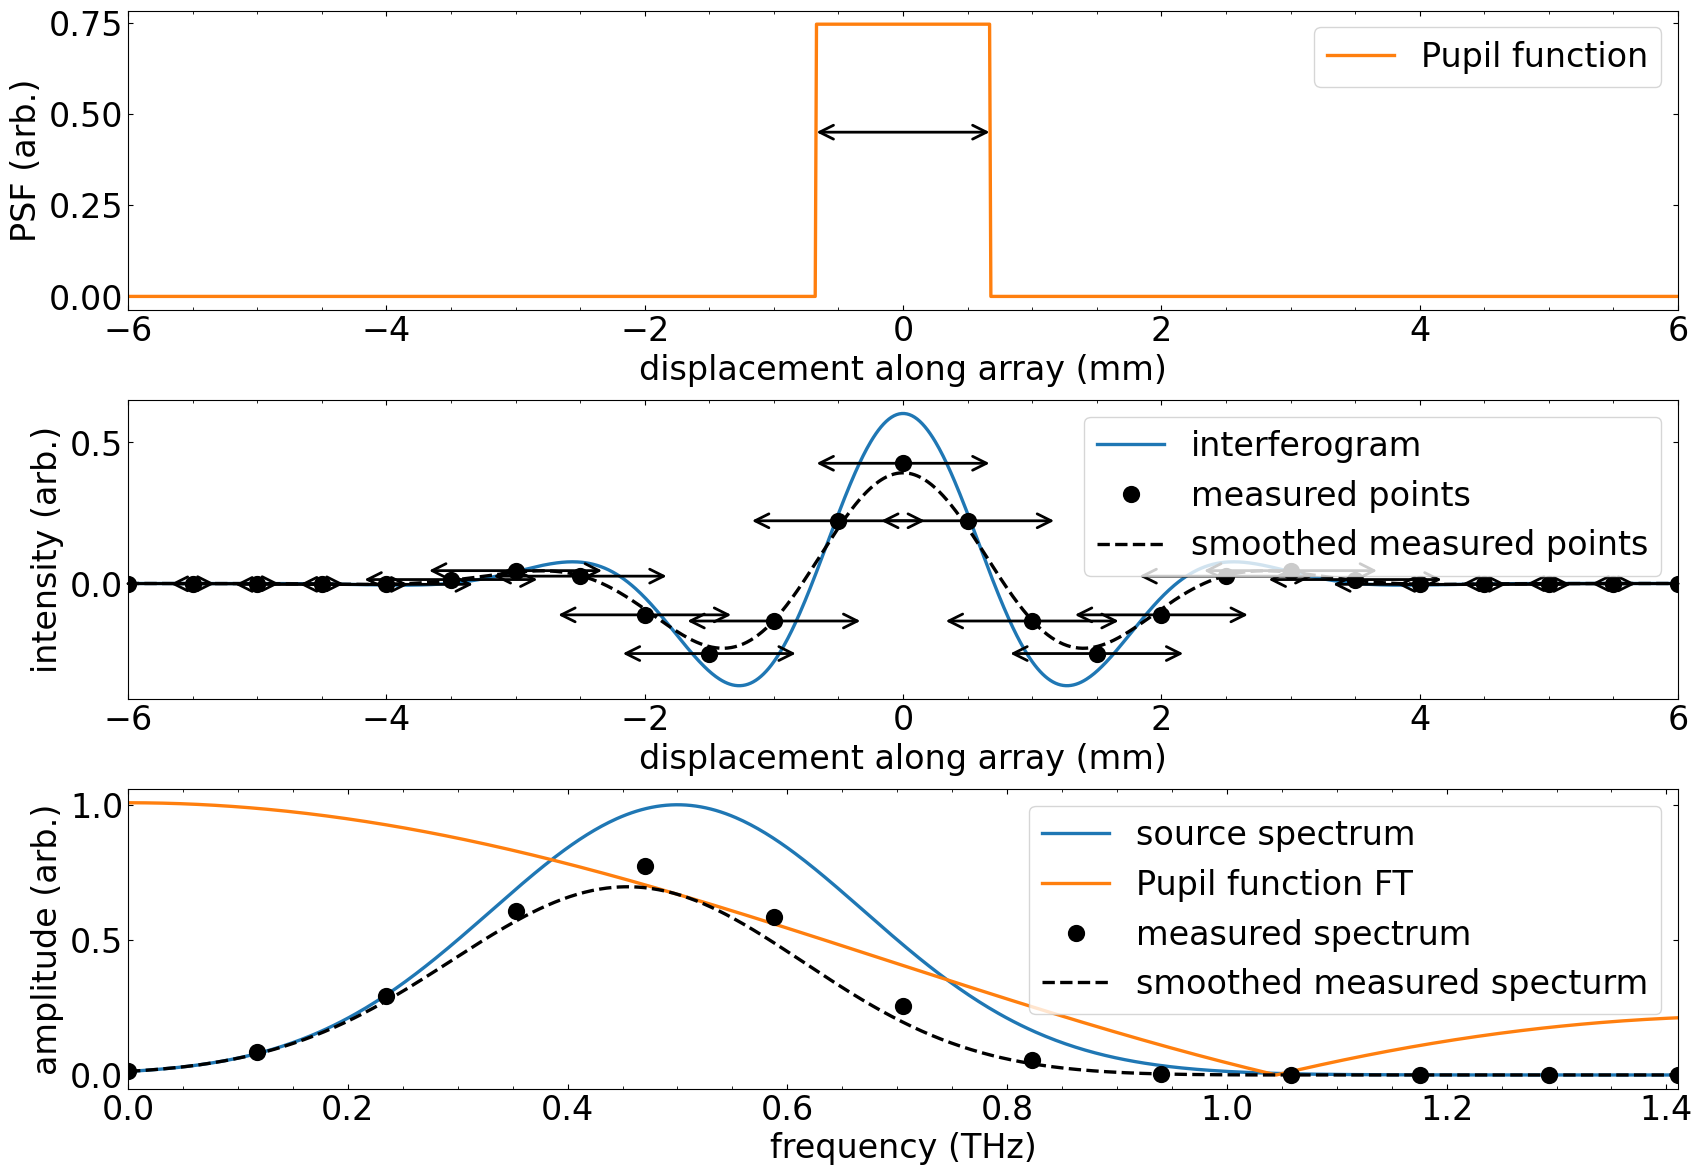

In [33]:

fig, axs = plt.subplots(3, 1, figsize= (20, 14), gridspec_kw= {"hspace": 0.3})

# axs[0].plot(np.fft.fftshift(displacement), np.fft.fftshift(IRF), linestyle= "none", marker= "o", color= "tab:blue", label= "resolvable IRF")
axs[0].plot(np.fft.fftshift(displacement_smooth), np.fft.fftshift(IRF_smooth), color= "tab:orange", label= "Pupil function")
axs[0].annotate("", xy= (-IRF_FWHM/2, K_FWHM/2), xytext= (IRF_FWHM/2, K_FWHM/2), arrowprops= {"arrowstyle": "<->", "shrinkA": 0, "shrinkB": 0, "linewidth": 2, "mutation_scale": 25}, label= "diode width")
axs[0].set(xlabel= "displacement along array (mm)", ylabel= "PSF (arb.)", xlim= (displacement.min(), displacement.max()))
axs[0].legend()

axs[1].plot(np.fft.fftshift(displacement_smooth), target_smooth, color= "tab:blue", label= "interferogram")
axs[1].plot(np.fft.fftshift(displacement), convol, color= "k", linestyle= "none", marker= "o", label= "measured points")
for x, I in zip(np.fft.fftshift(displacement), convol):
    if x - IRF_FWHM/2 < displacement.min():
        axs[1].annotate("", xy= (displacement.min(), I), xytext= (x +IRF_FWHM/2, I), arrowprops= {"arrowstyle": "<-", "shrinkA": 0, "shrinkB": 0, "linewidth": 2, "mutation_scale": 25})
    elif x + IRF_FWHM/2 > displacement.max():
        axs[1].annotate("", xy= (x -IRF_FWHM/2, I), xytext= (displacement.max(), I), arrowprops= {"arrowstyle": "->", "shrinkA": 0, "shrinkB": 0, "linewidth": 2, "mutation_scale": 25})
    else:
        axs[1].annotate("", xy= (x -IRF_FWHM/2, I), xytext= (x +IRF_FWHM/2, I), arrowprops= {"arrowstyle": "<->", "shrinkA": 0, "shrinkB": 0, "linewidth": 2, "mutation_scale": 25})

axs[1].plot(np.fft.fftshift(displacement_smooth), convol_smooth, color= "k", linestyle= "--", label= "smoothed measured points")
axs[1].set(xlabel= "displacement along array (mm)", ylabel= "intensity (arb.)", xlim= (displacement.min(), displacement.max()))
axs[1].legend()

#axs[2].plot(freqs, target_spec, linestyle= "none", marker= "o", color= "tab:blue", label= "resolvable source spectrum")
axs[2].plot(freqs_smooth, target_smooth_spec, color= "tab:blue", label= "source spectrum")
#axs[2].plot(freqs, IRF_spec, linestyle= "none", marker= "o", color= "tab:orange", label= "resolvable IRF FT")
axs[2].plot(freqs_smooth, IRF_smooth_spec, color= "tab:orange", label= "Pupil function FT")
axs[2].plot(freqs, convol_spec, linestyle= "none", marker= "o", color= "k", label= "measured spectrum")
axs[2].plot(freqs_smooth, convol_smooth_spec, color= "k", linestyle= "--", label= "smoothed measured specturm")
axs[2].set(xlabel= "frequency (THz)", ylabel= "amplitude (arb.)", xlim= (freqs.min(), freqs.max()))
axs[2].legend()

plt.show()

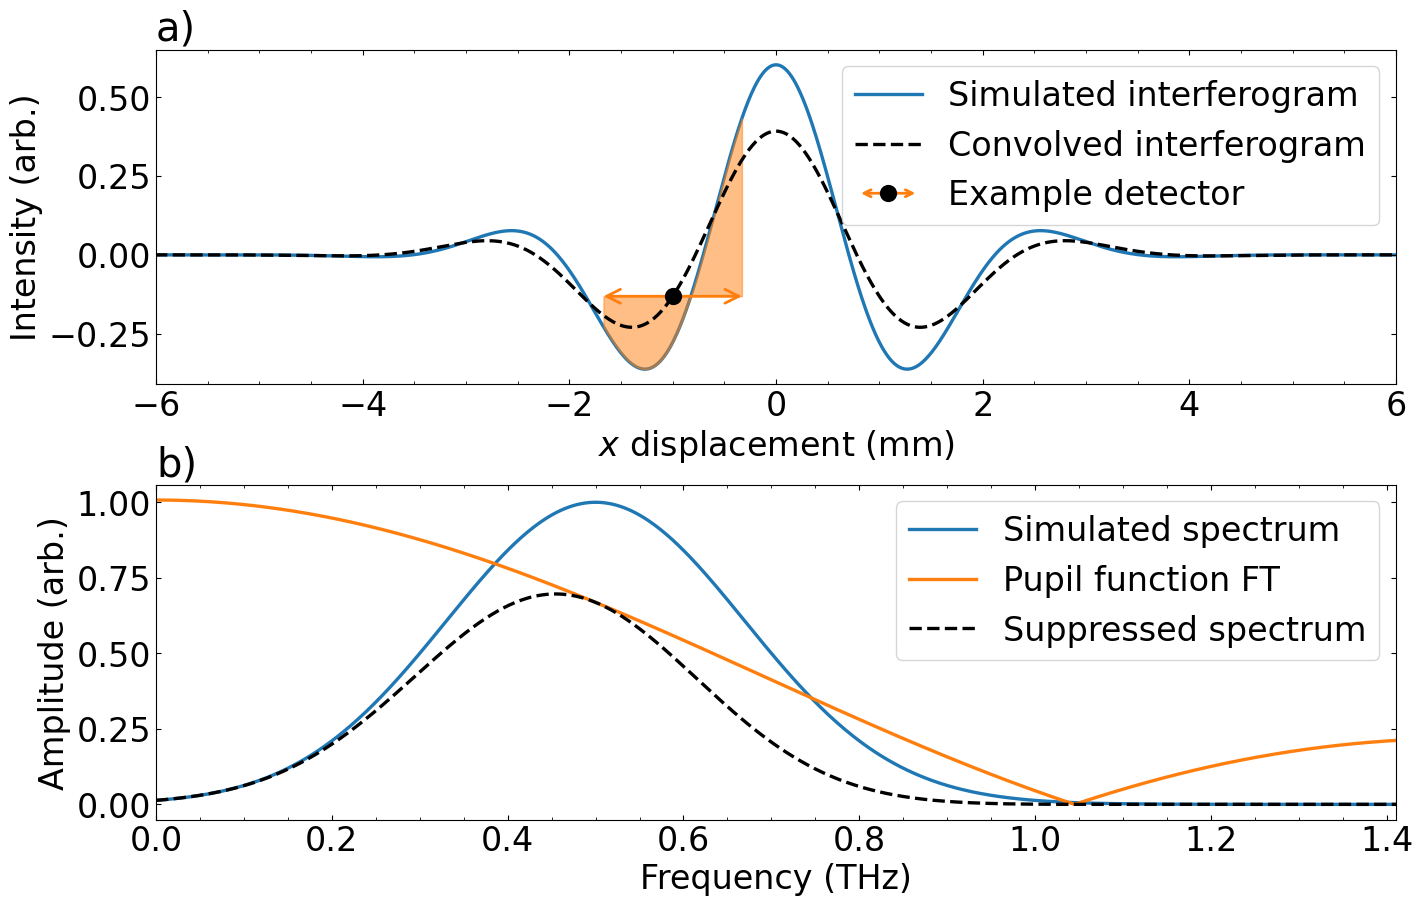

In [36]:
# 1. Define the Custom Legend Handler
class HandlerFancyArrowPatch(mpl_legend_handler.HandlerPatch):
    """Custom handler for FancyArrowPatch objects."""
    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        # Create a simplified arrow representation for the legend key
        
        # Determine the length and start position for the arrow within the key box
        # We want the arrow to span most of the legend key width (width)
        x_start = xdescent + 0.05 * width
        x_end = xdescent + 0.95 * width
        y_center = ydescent + 0.5 * height

        # Create a new FancyArrowPatch for the legend using the original's properties
        # Note: We use an arc connection style, which looks nice in the key
        p = patches.FancyArrowPatch(
            (x_start, y_center), 
            (x_end, y_center),
            arrowstyle=orig_handle.get_arrowstyle(),
            color=orig_handle.get_facecolor(),
            linewidth=orig_handle.get_linewidth(),
            mutation_scale=orig_handle.get_mutation_scale() * 0.5, # Scale down the head size
            transform=trans
        )
        p.set_clip_on(False) # Ensure the arrow isn't clipped by the legend box boundary
        
        return [p]


x_example = -1 # mm
convol_example = cs.closest(convol_smooth, np.fft.fftshift(displacement_smooth), x_example)

fig, axs = plt.subplots(2, 1, figsize= (16, 10), gridspec_kw= {"hspace": 0.3})
[ax.set_title(label, loc= "left") for ax, label in zip(axs, ["a)","b)"])]

axs[0].plot(np.fft.fftshift(displacement_smooth), target_smooth, color= "tab:blue", label= "Source interferogram", zorder= 1)
axs[0].plot(np.fft.fftshift(displacement_smooth), convol_smooth, color= "k", linestyle= "--", label= "Measured interferogram", zorder= 3)
axs[0].set(xlabel= r"$x$ displacement (mm)", ylabel= "Intensity (arb.)", xlim= (displacement.min(), displacement.max()))

axs[0].plot(x_example, convol_example, color= "k", linestyle= "none", marker= "o", zorder= 4)
axs[0].annotate("", xy= (x_example -IRF_FWHM/2, convol_example), xytext= (x_example +IRF_FWHM/2, convol_example), zorder= 2,
                arrowprops= {"arrowstyle": "<->", "shrinkA": 0, "shrinkB": 0, "linewidth": 2, "mutation_scale": 25, "color": "tab:orange"})

x_fill = np.fft.fftshift(displacement_smooth)[(x_example -IRF_FWHM/2 <= np.fft.fftshift(displacement_smooth)) & (np.fft.fftshift(displacement_smooth) <= x_example +IRF_FWHM/2)]
y_fill = target_smooth[(x_example -IRF_FWHM/2 <= np.fft.fftshift(displacement_smooth)) & (np.fft.fftshift(displacement_smooth) <= x_example +IRF_FWHM/2)]
axs[0].fill_between(x_fill, y_fill, y2= convol_example, color= "tab:orange", alpha= 0.5)

labels = ["Simulated interferogram", "Convolved interferogram", "Example detector"]
handles = [mpllines.Line2D([], [], color='tab:blue'),
           mpllines.Line2D([], [], color= "k", linestyle= "--"),
           (patches.FancyArrowPatch(0, 0, arrowstyle= "<->", shrinkA= 0, shrinkB= 0, linewidth= 2, mutation_scale= 25, color= "tab:orange"),
           mpllines.Line2D([], [], marker= "o", color= "k", linestyle= "none"))]
axs[0].legend(handles, labels, handler_map={patches.FancyArrowPatch: HandlerFancyArrowPatch()}, loc= "upper right")

#axs[1].plot(freqs, target_spec, linestyle= "none", marker= "o", color= "tab:blue", label= "resolvable source spectrum")
axs[1].plot(freqs_smooth, target_smooth_spec, color= "tab:blue", label= "Simulated spectrum")
#axs[1].plot(freqs, IRF_spec, linestyle= "none", marker= "o", color= "tab:orange", label= "resolvable IRF FT")
axs[1].plot(freqs_smooth, IRF_smooth_spec, color= "tab:orange", label= "Pupil function FT")
axs[1].plot(freqs_smooth, convol_smooth_spec, color= "k", linestyle= "--", label= "Suppressed spectrum")
axs[1].set(xlabel= "Frequency (THz)", ylabel= "Amplitude (arb.)", xlim= (freqs.min(), freqs.max()))
axs[1].legend()

fig.savefig("./graphs/width_demo.png", bbox_inches= "tight")
plt.show()

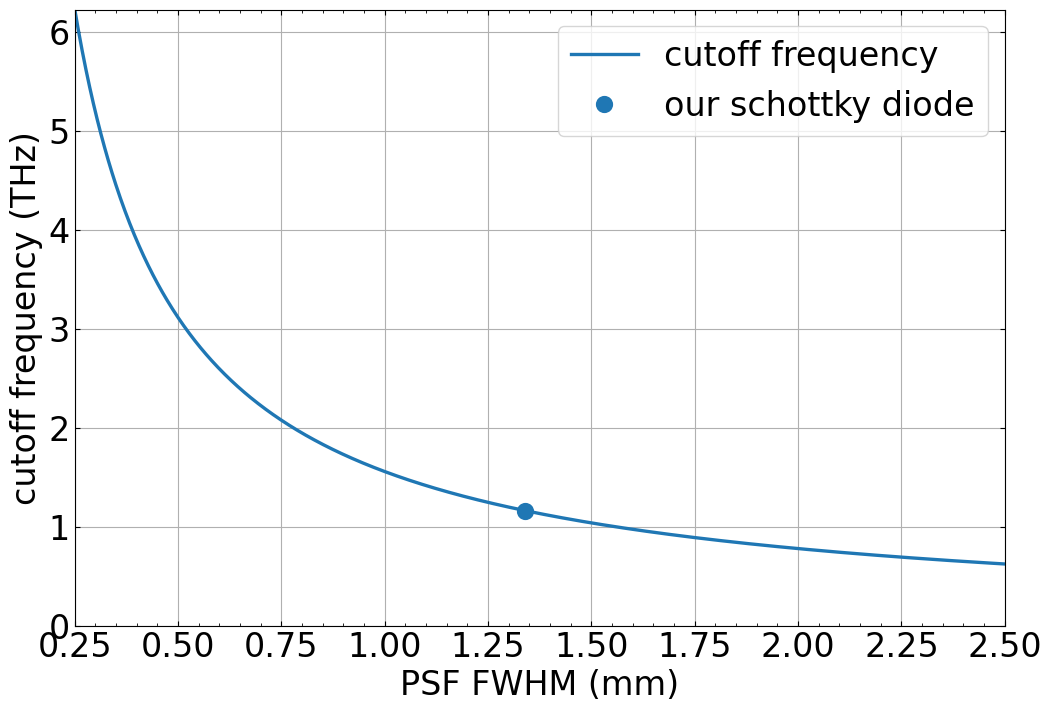

In [35]:
def cutoff_frequency(PSF_FWHM, theta):
    """
    Calculate the cutoff frequency for a given FWHM and angle theta.
    
    Parameters:
    PSF_FWHM (float): Full width at half maximum in m.
    theta (float): Angle in degrees.
    
    Returns:
    float: Cutoff frequency in Hz.
    """
    return sinc_half * C / (2*np.pi*PSF_FWHM*np.sin(np.deg2rad(theta)))

theta = 200/60 #in degrees
x_FWHM = np.linspace(0.25, 2.5, 1000) *1e-3 # in m
cutoffs = cutoff_frequency(x_FWHM, theta) # in Hz

fig, axs = plt.subplots(figsize= (12, 8))
axs.plot(x_FWHM *1e3, cutoffs*1e-12, color= "tab:blue", label= "cutoff frequency")
axs.plot(IRF_FWHM, cutoff_frequency(IRF_FWHM *1e-3, theta)*1e-12, marker= "o", linestyle= "none", color= "tab:blue", label= "our schottky diode")
axs.set(xlabel= "PSF FWHM (mm)", ylabel= "cutoff frequency (THz)", xlim= (x_FWHM.min() *1e3, x_FWHM.max() *1e3), ylim= (0, cutoffs.max()*1e-12))
axs.legend()
axs.grid()
plt.show()